# Transient Universe

Model to use:

$ f(x) = \begin{cases} b & \text{if } t < 0 \\ b + A\exp{-\alpha(t-t_0)} & \text{if } t \geq t_0 \end{cases} $

Priors:

$b \in \text{Uniform} [0,50]$\
$t_0 \in \text{Uniform} [0,100]$\
$\ln(\alpha) \text{Uniform} [-5,5]$


First, read the data

In [225]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities")
from Utilities import plot_settings

In [226]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Exam\Data\transient.npy")

In [227]:
time = data.T[0]
flux = data.T[1]
ferr = data.T[2]

In [228]:
import scipy

Exploring data

Text(0.5, 1.0, 'Raw data')

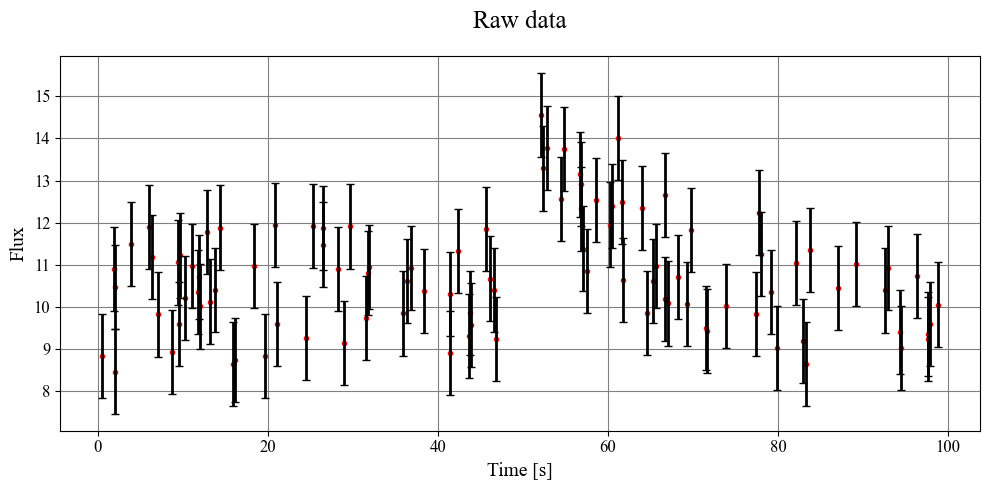

In [229]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True)
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')

1. **Using one of the MCMC sampler that we looked at in class (emcee, pymc), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{A, t_0,b,\alpha\}$.**

Define the model and initial parameters

In [230]:
def model(x):
    A, t0, alpha, b = x
    return np.where(time < t0, b, b + A * np.exp(-alpha * (time - t0)))

In [240]:
b_estimate = np.mean(flux[time < 40])
A_estimate = np.max(flux)-b_estimate
t0_estimate= time[np.argmax(flux)]
a = np.where(flux-b_estimate < A_estimate/np.e , time, flux)
alpha_estimate = 1/(a[a>t0_estimate][0]-t0_estimate)

In [241]:
x0 = np.array([A_estimate, t0_estimate, alpha_estimate, b_estimate])

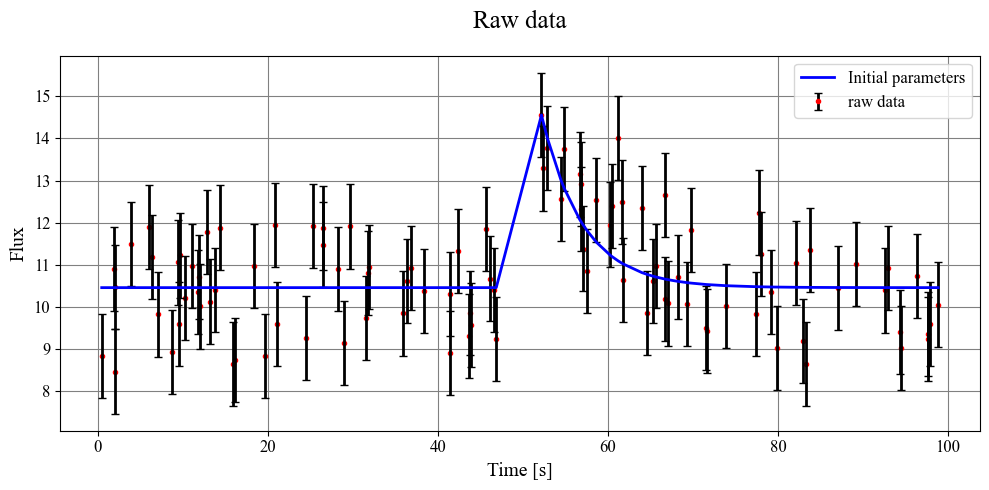

In [242]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
plt.plot(time, model(x0), lw=2, color='blue', label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Raw data')
plt.legend()

Define loglikelihood

In [243]:
def pdf(x):
    A, t0, alpha, b = x
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    if np.any(np.isinf(np.exp(-alpha * (time - t0)))):
        return -np.inf
    output = np.where(time < t0, b,  b + A * np.exp(-alpha * (time - t0)))
    return output

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, t0, alpha, b = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= t0 <= 100 and np.exp(-5) <= alpha <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((flux - y_model) / ferr)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [244]:
import emcee

In [245]:
n_walkers = 10 # number of walkers I want to crawl the posterior with
n_dim = 4 # dimension of the parameter space
n_steps = int(1e5)

In [ ]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, posterior)

In [248]:
x1 = x0 + 1e-2*np.random.randn(n_walkers,n_dim)

In [249]:
sampler.run_mcmc(initial_state=x1, nsteps=n_steps)

State([[ 8.35973013 48.45461694  0.148574   10.40784012]
 [ 8.80983762 48.56328085  0.15611049 10.0560452 ]
 [ 5.07026645 48.45560391  0.11550441 10.26715216]
 [ 6.31470141 46.90307812  0.10825811 10.16134859]
 [ 5.95402345 48.9887812   0.1216312  10.21544467]
 [ 9.2674349  48.10915278  0.1637246  10.16327222]
 [ 3.31320579 51.76936391  0.09912271 10.32894782]
 [ 4.60016709 49.68658904  0.11069877 10.20415289]
 [ 4.45961271 49.99726906  0.08832532 10.17027171]
 [ 4.54595927 51.90008323  0.11479957 10.2218216 ]], log_prob=[-69.10400487 -70.99633406 -67.04671361 -67.06660483 -66.44133624
 -69.13804441 -67.04616412 -66.84809225 -67.36925547 -67.32956269], blobs=None, random_state=('MT19937', array([ 638621275, 2812625255, 1164173792,  209045228,  525992772,
       4182142152, 3530255945,  589887586,   27828347,  421574959,
       3461650309, 3021779024, 3259124468, 2850714887, 1869517121,
       3186437026, 1476001515, 3210087682, 2228289017, 4114870230,
       2230842363,   27172233, 321

2. **Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3)**.



In [ ]:
samples = sampler.get_chain()

In [255]:
samples.shape

(100000, 10, 4)

In [264]:
labels = [r'$A$', r'$t_0$', r'$\alpha$', r'$b$']

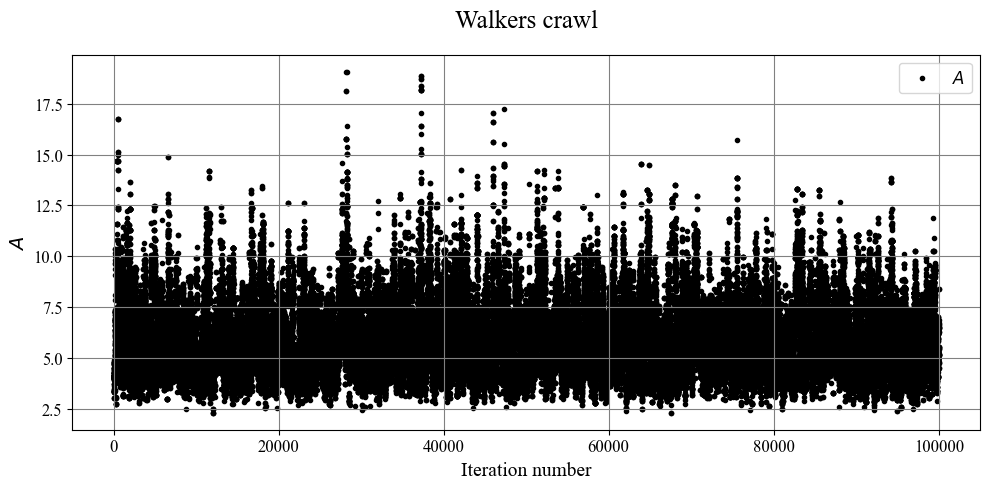

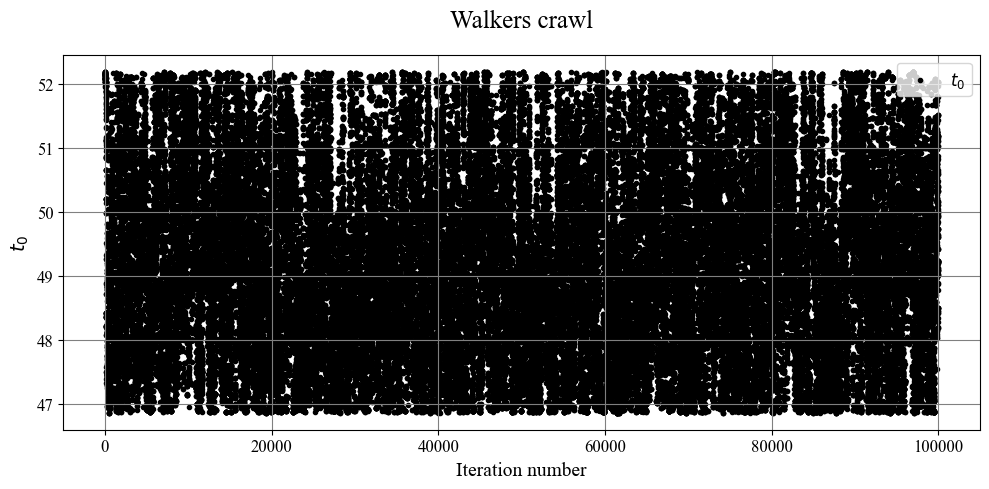

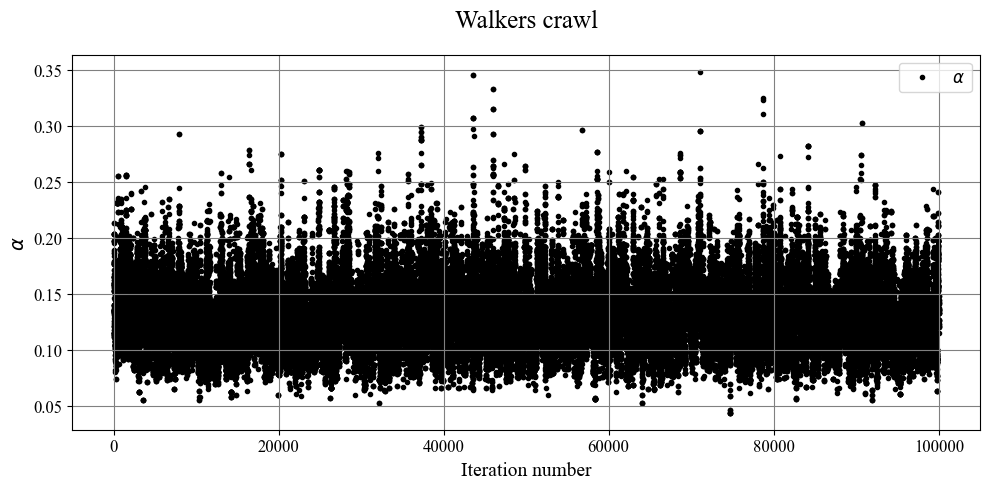

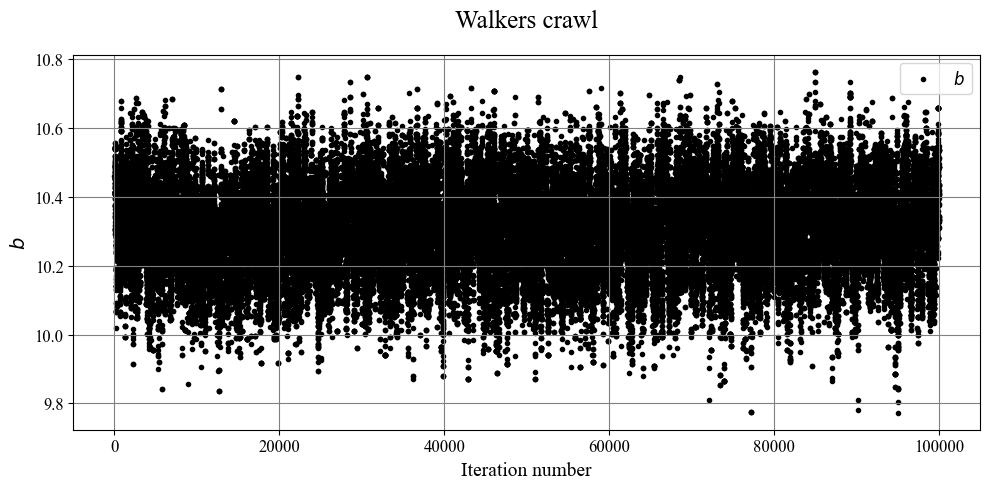

In [265]:
for i in range(n_dim):
    plt.scatter(np.linspace(0,n_steps,n_steps),samples[:, 0,i], marker='.', color='black', label=labels[i])
    plt.ylabel(labels[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Walkers crawl')
    plt.show()


In [ ]:
tau = sampler.get_autocorr_time()
print(f'Autocorrelation time is {tau}')

Autocorrelation time is [92.9395342  90.41641329 73.67572202 68.24760026]


In [273]:
acceptance_rate = sampler.acceptance_fraction
print(f'Acceptance rates are {acceptance_rate}')

Acceptance rates are [0.53023 0.52897 0.52832 0.52903 0.53027 0.53018 0.52831 0.53066 0.53244
 0.52883]


Discard 10000 points and thin the flattened (only the walker number dimension is flattened now) chains to down_sample...one point every $max(\tau)$ points

In [281]:
samples = sampler.get_chain(discard=10000, thin=int(max(np.array(tau))),flat=True)

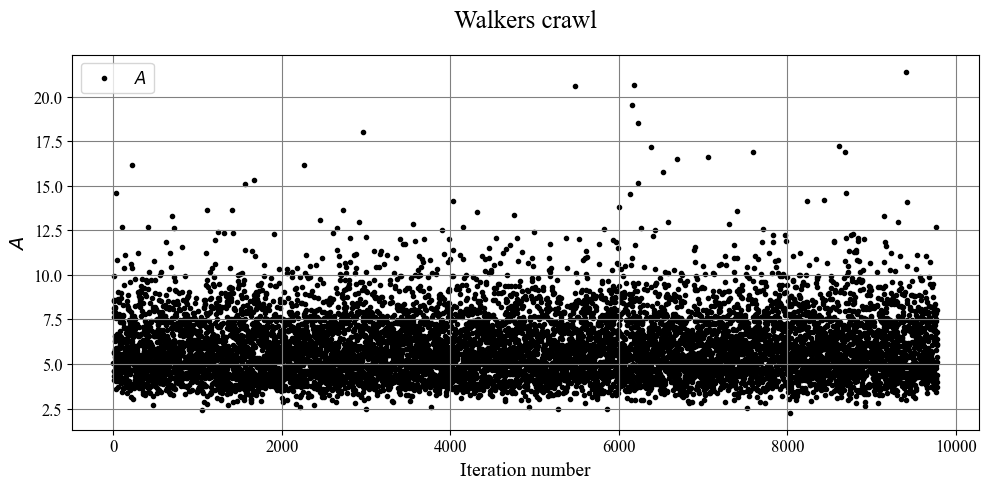

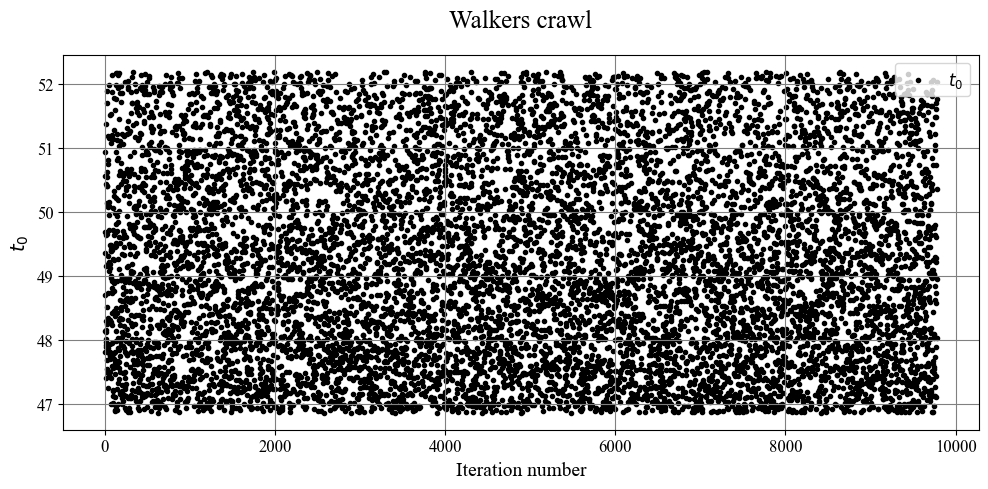

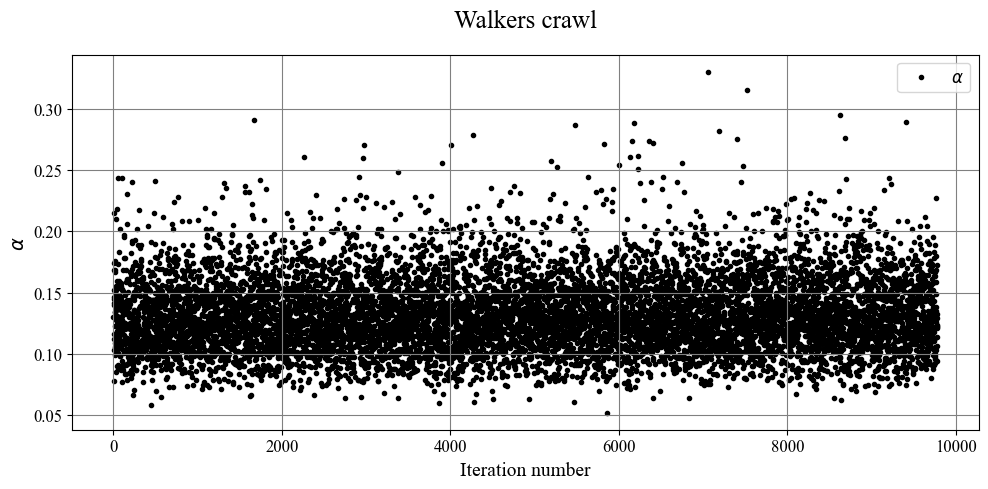

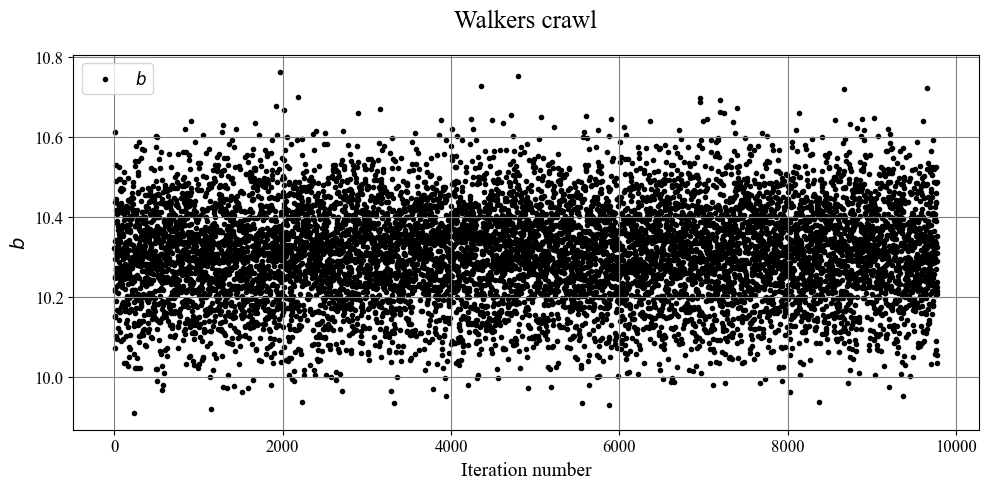

In [284]:
for i in range(n_dim):
    plt.scatter(np.linspace(0,samples[:,i].size,samples[:,i].size),samples[:,i], marker='.', color='black', label=labels[i])
    plt.ylabel(labels[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.title('Walkers crawl')
    plt.show()


3. **Make a corner plot of the $4-D$ parameter space, with labels, $[68\%,95\%]$ credible levels and quantiles, and titles**

In [285]:
import corner

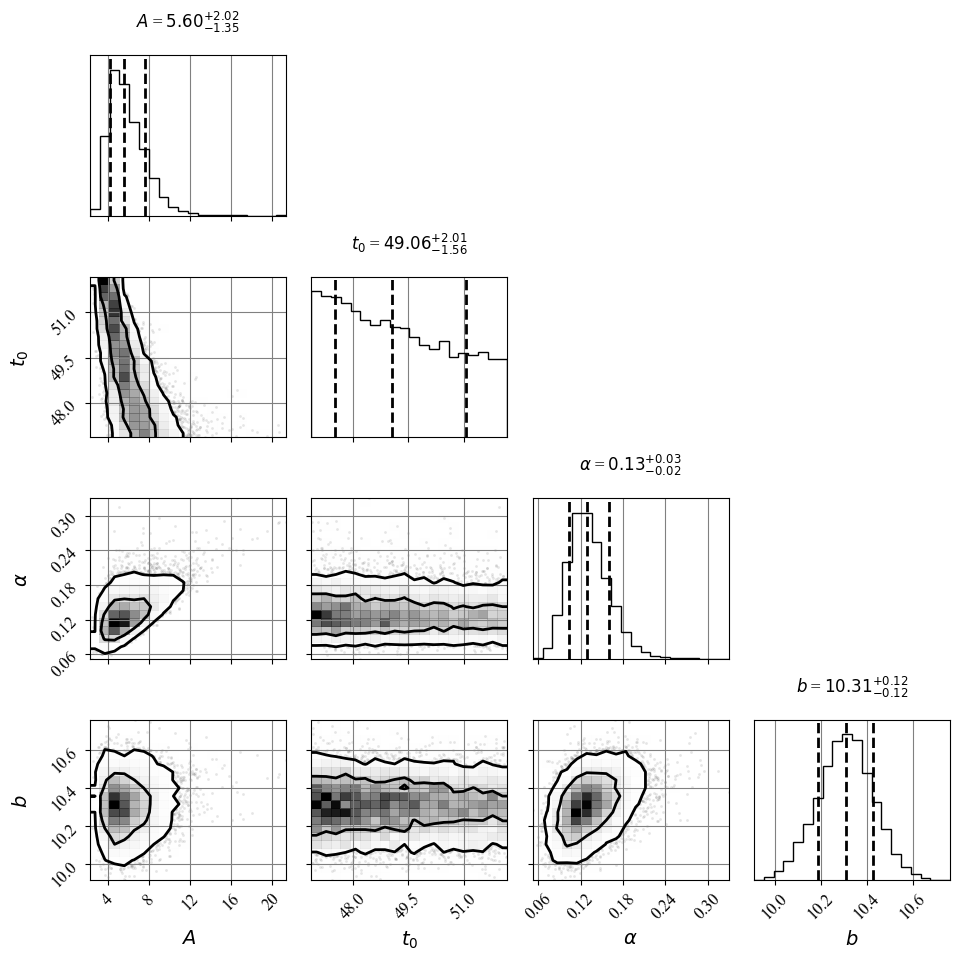

In [293]:
fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],     # 68% interval
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),        # draw 1σ and 2σ contours
    plot_datapoints=True,
    fill_contours=False
)

Comments on corner plot:
1. There is linear correlation between A and t0. 
2. $\alpha$ is independent from $t_0$
3. b is independent from $t_0$

4. **Now choose 100 samples randomly from your burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.**

In [317]:
randoms = np.vstack([np.random.choice(samples[:,0], size=100) ,np.random.choice(samples[:,1], size=100) ,np.random.choice(samples[:,2], size=100), np.random.choice(samples[:,3], size=100)]).T

Text(0.5, 1.0, 'Randomly chosen parameter estimates')

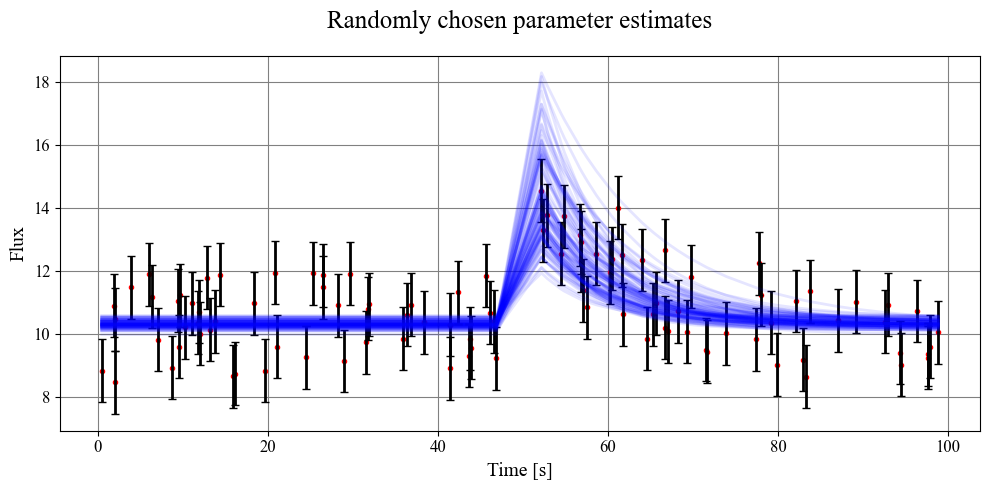

In [321]:
plt.errorbar(time, flux, ferr, fmt='.', color='red', linestyle='None', ecolor='black', capsize=3,barsabove=True, label='raw data')
for ran in randoms:
    plt.plot(time, model(ran), lw=2, color='blue', alpha=0.1, label='Initial parameters')
plt.xlabel('Time [s]')
plt.ylabel('Flux')
plt.title('Randomly chosen parameter estimates')

5. **For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0 = \chi^{+Y}_{-Z}$**

In [400]:
def plot_marginal(i):
    c, b, _ = plt.hist(samples[:, i], bins='scott', density=False,
                       color='blue', alpha=0.4, edgecolor='black', histtype='barstacked')

    median = np.median(samples[:, i])
    mean = np.mean(samples[:, i])
    plt.axvline(median, 0, 1, linestyle='--', color='orange', label=f'median = {median:.2f}')
    plt.axvline(mean, 0, 1, linestyle='-.', color='brown', label=f'mean = {mean:.3f}')

    low, high = np.quantile(samples[:, i], [0.05, 0.95])
    plt.axvline(low, 0, 1, color='brown', linestyle='-.', label='90% credible region')
    plt.axvline(high, 0, 1, color='brown', linestyle='-.')

    plt.xlabel(labels[i])
    plt.ylabel('Counts')
    plt.legend()

    x_text = b[0] + 0.7 * (b[-1] - b[0])
    y_text = max(c) * 0.8

    # LaTeX notation with superscript and subscript
    plt.text(
        x_text,
        y_text,
        rf"{labels[i]}$^{{{high:.2f}}}_{{{low:.2f}}}$",
        fontsize=20
    )

    plt.show()
    print()


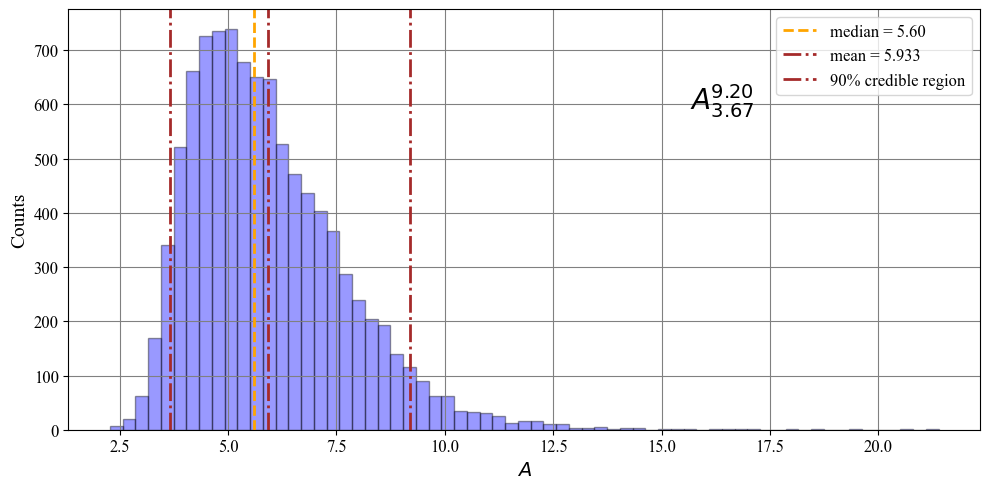

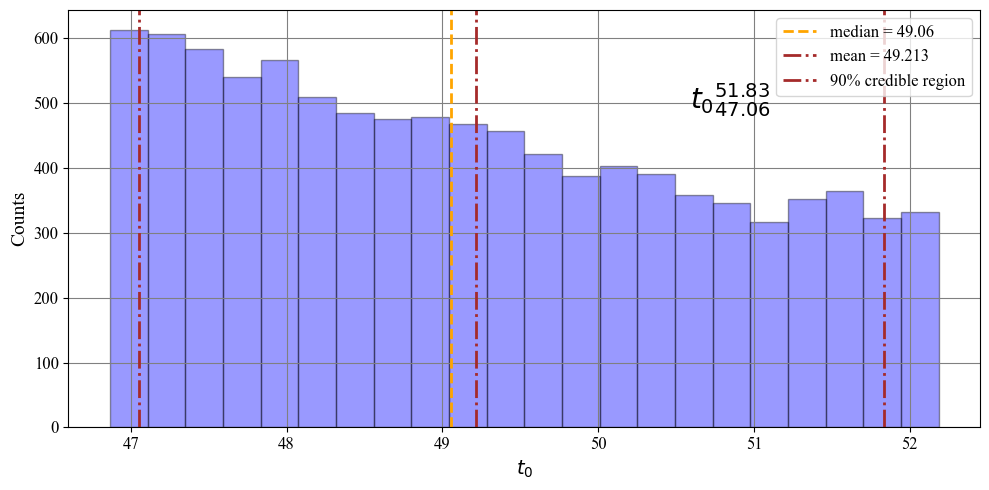

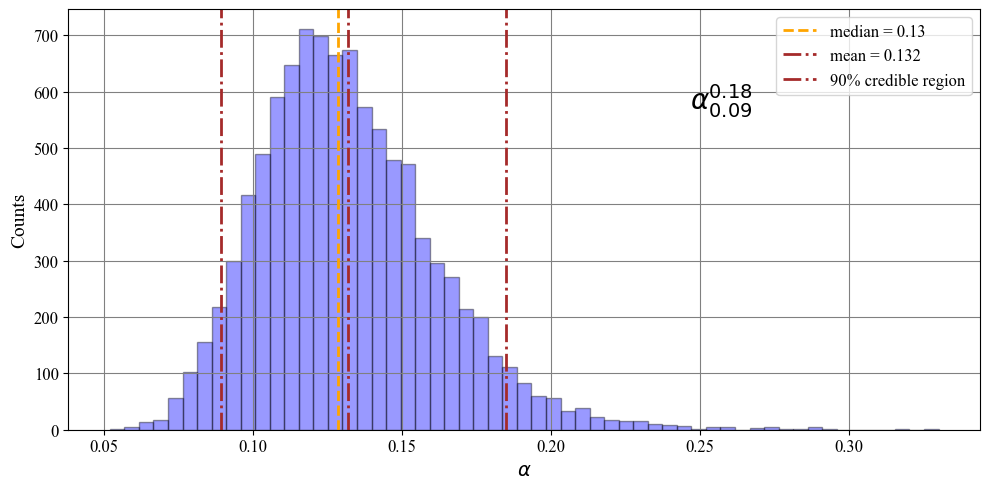

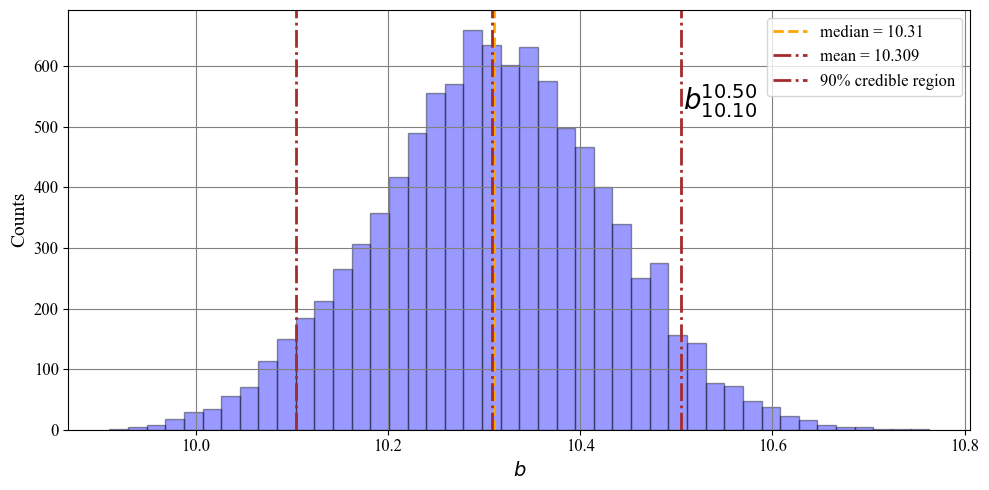

In [401]:
for i in range(n_dim):
    plot_marginal(i)